## Hourly Energy Consumption Forecasting with XGBoost and Weather Data

In [304]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap # Added import
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from meteostat import Stations, Hourly
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('fivethirtyeight')

## Load and Preprocess Energy Consumption Data

Load the PJME hourly energy consumption data. Ensure the index is sorted and filter the date range.

### Feature Engineering: Holidays and Calendar Features

Create features based on the date:
*   **Holidays:** Identify US Federal Holidays. Create an extended holiday list including 'bridge days' around July 4th when it falls mid-week, as energy consumption patterns might change on days adjacent to holidays.
*   **Weekends:** Flag Saturdays and Sundays.
*   **Combined Day Off:** Create a single boolean feature `is_dayoff` indicating if the day is either a holiday or a weekend.
*   **Calendar Features:** Extract standard time-based features like hour, day of week, month, year, etc.

In [305]:
# Load PJME hourly energy consumption data
pjme = (
    pd.read_csv(
        '../data/3/PJME_hourly.csv',
        index_col='Datetime', # Use column name
        parse_dates=['Datetime'] # Use column name
    )
    .sort_index()
    .loc['2003-01-01':'2018-08-02']
)

# --- Feature Engineering: Holidays and Calendar Features ---

# Build an extended holiday list including bridge days for July 4th
cal = USFederalHolidayCalendar()
fed_hols = cal.holidays(start=pjme.index.min(), end=pjme.index.max())
extended_hols = set(fed_hols)

for year in range(pjme.index.year.min(), pjme.index.year.max() + 1):
    july4 = datetime(year, 7, 4)
    wd = july4.weekday()
    if wd == 1: # Tuesday
        extended_hols.add(july4 - timedelta(days=1)) # Add Monday before
    elif wd == 2: # Wednesday
        extended_hols.add(july4 + timedelta(days=1)) # Add Thursday after
        extended_hols.add(july4 + timedelta(days=2)) # Add Friday after
    elif wd == 3: # Thursday
        extended_hols.add(july4 + timedelta(days=1)) # Add Friday after

all_hols = pd.DatetimeIndex(sorted(extended_hols))

# Create holiday and weekend flags
pjme['is_holiday'] = pjme.index.normalize().isin(all_hols)
pjme['is_weekend'] = pjme.index.weekday >= 5

# Combine into a single 'is_dayoff' flag
pjme['is_dayoff'] = pjme['is_holiday'] | pjme['is_weekend']
pjme.drop(columns=['is_holiday', 'is_weekend'], inplace=True)

# Create calendar features
pjme['hour']       = pjme.index.hour
pjme['dayofweek']  = pjme.index.weekday
pjme['quarter']    = pjme.index.quarter
pjme['month']      = pjme.index.month
pjme['year']       = pjme.index.year
pjme['dayofyear']  = pjme.index.dayofyear
pjme['dayofmonth'] = pjme.index.day
pjme['weekofyear'] = pjme.index.isocalendar().week.astype(int)

print(f'Data shape: {pjme.shape}')
print(f'Index monotonic? {pjme.index.is_monotonic_increasing}')
pjme.head()

Data shape: (136608, 10)
Index monotonic? True


,PJME_MW,is_dayoff,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2003-01-01 00:00:00,27008.0,True,0,2,1,1,2003,1,1,1
2003-01-01 01:00:00,25591.0,True,1,2,1,1,2003,1,1,1
2003-01-01 02:00:00,24235.0,True,2,2,1,1,2003,1,1,1
2003-01-01 03:00:00,23121.0,True,3,2,1,1,2003,1,1,1
2003-01-01 04:00:00,22445.0,True,4,2,1,1,2003,1,1,1


## Fetch and Process Weather Data

Fetch hourly weather data from Meteostat for several weather stations near the PJME region (Philadelphia, Newark, Baltimore, Washington D.C.). This provides exogenous variables that strongly influence energy demand.

In [306]:
# Define time range and target weather stations (ICAO codes)
start = datetime(2002, 12, 31) # Start slightly before energy data for join
end   = datetime(2018, 8, 4)   # End slightly after energy data for join
target_icaos = ['KPHL', 'KEWR', 'KBWI', 'KDCA']

# Find stations near Philadelphia (as a central point)
stations_query = Stations()
stations_query = stations_query.nearby(39.95, -75.17)
stations_query = stations_query.inventory('hourly', (start, end))
all_stations_df = stations_query.fetch()

# Filter for the target stations
target_stations_df = all_stations_df[all_stations_df['icao'].isin(target_icaos)]
station_ids = target_stations_df.index.tolist()

# Fetch hourly data for all target stations
print(f"Fetching weather data for stations: {station_ids}")
weather_all = Hourly(station_ids, start, end).fetch()

print(f"Raw weather data shape: {weather_all.shape}")
weather_all.head()

Fetching weather data for stations: ['72408', '72502', '72406', '72405']
Raw weather data shape: (546679, 11)
Raw weather data shape: (546679, 11)


temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
station time                                                                   
72408   2002-12-31 00:00:00   5.0  -1.0  65.0   0.0   NaN  140.0  11.2   NaN   
        2002-12-31 01:00:00   5.0  -0.6  67.0   0.0   NaN  130.0   7.6   NaN   
        2002-12-31 02:00:00   4.4   0.0  73.0   0.0   NaN   90.0   9.4   NaN   
        2002-12-31 03:00:00   5.0   0.6  73.0   0.0   NaN   90.0   7.6   NaN   
        2002-12-31 04:00:00   5.0   1.7  79.0   NaN   NaN   60.0   5.4   NaN   

                               pres  tsun  coco  
station time                                     
72408   2002-12-31 00:00:00  1025.1   NaN   NaN  
        2002-12-31 01:00:00  1024.7   NaN   NaN  
        2002-12-31 02:00:00  1023.8   NaN   NaN  
        2002-12-31 03:00:00  1023.3   NaN   NaN  
        2002-12-31 04:00:00  1022.9   NaN   NaN

### Average Weather Data and Handle Missing Values

Average the relevant weather features (temperature, dew point, humidity, precipitation, wind speed) across the selected stations for each hour to get a representative weather profile for the region. Handle potential missing values by forward-filling, assuming weather conditions persist for short periods.

In [307]:
# Select relevant columns and average across stations for each timestamp
weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wspd']
average_data = (
    weather_all
    .groupby(level='time')
    .mean(numeric_only=True) # Ensure only numeric columns are averaged
    [weather_cols]
)

# Forward-fill missing values (simple imputation)
# Check initial missing values
print("Missing weather values BEFORE fill:")
print(average_data.isnull().sum())
average_data.ffill(inplace=True)

# Check missing values again and shape
print("\nMissing weather values AFTER fill:")
print(average_data.isnull().sum())
print(f"\nAveraged weather data shape: {average_data.shape}")
average_data.head()

Missing weather values BEFORE fill:
temp      0
dwpt      0
rhum      0
prcp    407
wspd      1
dtype: int64

Missing weather values AFTER fill:
temp    0
dwpt    0
rhum    0
prcp    0
wspd    0
dtype: int64

Averaged weather data shape: (136681, 5)


,temp,dwpt,rhum,prcp,wspd
time,,,,,
2002-12-31 00:00:00,5.275,0.850,74.0,0.0,10.20
2002-12-31 01:00:00,4.700,0.600,75.5,0.0,7.05
2002-12-31 02:00:00,4.725,0.875,76.5,0.0,6.15
2002-12-31 03:00:00,5.425,0.950,73.0,0.0,3.80
2002-12-31 04:00:00,5.150,1.525,77.5,0.0,2.70


## Combine Energy and Weather Data

Join the energy consumption data with the averaged weather data based on the timestamp index. Drop any remaining rows with missing values (likely at the very beginning if weather data didn't cover the full energy range after filling).

In [308]:
# Join energy data with averaged weather data
pjme_weather = pjme.join(average_data, how='left')

# Drop rows where weather data might still be missing (e.g., at the start)
initial_rows = len(pjme_weather)
pjme_weather.dropna(inplace=True)
final_rows = len(pjme_weather)

print(f"Combined data shape: {pjme_weather.shape}")
print(f"Rows dropped due to missing values: {initial_rows - final_rows}")
# print(pjme_weather.isnull().sum()) # Verify no missing values remain
pjme_weather.head()

Combined data shape: (136608, 15)
Rows dropped due to missing values: 0


,PJME_MW,is_dayoff,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temp,dwpt,rhum,prcp,wspd
2003-01-01 00:00:00,27008.0,True,0,2,1,1,2003,1,1,1,9.450,4.675,73.25,0.0,7.950
2003-01-01 01:00:00,25591.0,True,1,2,1,1,2003,1,1,1,9.300,4.750,74.00,0.0,7.400
2003-01-01 02:00:00,24235.0,True,2,2,1,1,2003,1,1,1,7.800,4.400,79.25,0.0,8.825
2003-01-01 03:00:00,23121.0,True,3,2,1,1,2003,1,1,1,7.775,4.200,79.00,0.0,6.950
2003-01-01 04:00:00,22445.0,True,4,2,1,1,2003,1,1,1,7.350,4.050,80.50,0.0,6.050


## Train/Validation/Test Split

Split the data chronologically to simulate a real-world forecasting scenario:
*   **Training Set:** First ~80% of the data.
*   **Validation Set:** Next ~10% of the data (used for early stopping).
*   **Test Set:** Final ~10% of the data (used for final model evaluation).

In [309]:
# Define split points based on time
total_hours = len(pjme_weather)
test_split_point = int(total_hours * 0.9)
val_split_point = int(total_hours * 0.8)

test_split_date = pjme_weather.index[test_split_point]
val_split_date = pjme_weather.index[val_split_point]

# Perform the split using the calculated dates
test_df = pjme_weather.loc[pjme_weather.index >= test_split_date].copy()
val_df = pjme_weather.loc[(pjme_weather.index >= val_split_date) & (pjme_weather.index < test_split_date)].copy()
train_df = pjme_weather.loc[pjme_weather.index < val_split_date].copy()

# Check proportions and sizes
total_len = len(pjme_weather)
train_len = len(train_df)
val_len = len(val_df)
test_len = len(test_df)
print(f"Total: {total_len} rows")
print(f"Train: {train_len} rows ({train_len/total_len:.1%})")
print(f"Val  : {val_len} rows ({val_len/total_len:.1%})")
print(f"Test : {test_len} rows ({test_len/total_len:.1%})")

Total: 136608 rows
Train: 109286 rows (80.0%)
Val  : 13661 rows (10.0%)
Test : 13661 rows (10.0%)


In [310]:
# Verify the chronological split
print("\n--- Split Verification ---")
print(f"Original sorted?    {pjme_weather.index.is_monotonic_increasing}")
print(f"Train ends at:    {train_df.index.max()}")
print(f"Val starts at:    {val_df.index.min()}")
print(f"Val ends at:      {val_df.index.max()}")
print(f"Test starts at:   {test_df.index.min()}")

# Confirm no overlap and chronological order within splits
assert train_df.index.max() < val_df.index.min()
assert val_df.index.max() < test_df.index.min()
assert train_df.index.is_monotonic_increasing
assert val_df.index.is_monotonic_increasing
assert test_df.index.is_monotonic_increasing
print("Split boundaries and ordering confirmed.")


--- Split Verification ---
Original sorted?    True
Train ends at:    2015-06-21 13:00:00
Val starts at:    2015-06-21 14:00:00
Val ends at:      2017-01-10 17:00:00
Test starts at:   2017-01-10 18:00:00
Split boundaries and ordering confirmed.
Train ends at:    2015-06-21 13:00:00
Val starts at:    2015-06-21 14:00:00
Val ends at:      2017-01-10 17:00:00
Test starts at:   2017-01-10 18:00:00
Split boundaries and ordering confirmed.


## Create Features (X) and Target (y)

Define a helper function to separate the features (X) from the target variable (y, which is `PJME_MW`). Apply this function to the train, validation, and test sets.

In [311]:
def create_Xy(df: pd.DataFrame, label: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into feature matrix X and target vector y.
    
    Args:
        df: Input DataFrame with features and the target column.
        label: Name of the target column.
    
    Returns:
        A tuple containing the feature DataFrame (X) and target Series (y).
    
    Raises:
        KeyError: If the label column is not found in the DataFrame.
    """
    if label not in df.columns:
        raise KeyError(f"Label column '{label}' not found in DataFrame")
    
    df_copy = df.copy()
    y = df_copy.pop(label)
    X = df_copy
    return X, y

In [312]:
TARGET = 'PJME_MW'
X_train, y_train = create_Xy(train_df, label=TARGET)
X_val, y_val = create_Xy(val_df, label=TARGET)
X_test, y_test = create_Xy(test_df, label=TARGET)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}, y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}, y_test shape:  {y_test.shape}")

X_train shape: (109286, 14), y_train shape: (109286,)
X_val shape:   (13661, 14), y_val shape:   (13661,)
X_test shape:  (13661, 14), y_test shape:  (13661,)


## Train XGBoost Model

Train an XGBoost Regressor model. Use the validation set for early stopping to prevent overfitting. Early stopping monitors the performance on the validation set (using RMSE by default for regression) and stops training if the performance doesn't improve for a specified number of rounds (50 in this case).

In [313]:
# Instantiate the XGBoost regressor
reg = xgb.XGBRegressor(
    n_estimators=1000,            # Maximum number of boosting rounds (trees)
    early_stopping_rounds=50,     # Stop if validation RMSE doesn't improve for 50 rounds
    learning_rate=0.01,           # Step size shrinkage (default 0.3 is often too high)
    objective='reg:squarederror', # Specify regression objective
    n_jobs=-1,                    # Use all available CPU cores
    random_state=42               # For reproducibility
)

# Fit the model using training data, evaluating on the validation set
print("Training XGBoost model...")
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100 # Print evaluation results every 100 rounds
)
print("Model training complete.")

Training XGBoost model...
[0]	validation_0-rmse:6369.30597	validation_1-rmse:6849.41613
[0]	validation_0-rmse:6369.30597	validation_1-rmse:6849.41613
[100]	validation_0-rmse:3125.52055	validation_1-rmse:3371.23560
[100]	validation_0-rmse:3125.52055	validation_1-rmse:3371.23560
[200]	validation_0-rmse:1989.77301	validation_1-rmse:2248.76445
[200]	validation_0-rmse:1989.77301	validation_1-rmse:2248.76445
[300]	validation_0-rmse:1529.04301	validation_1-rmse:1801.05941
[300]	validation_0-rmse:1529.04301	validation_1-rmse:1801.05941
[400]	validation_0-rmse:1311.18997	validation_1-rmse:1619.99267
[400]	validation_0-rmse:1311.18997	validation_1-rmse:1619.99267
[500]	validation_0-rmse:1195.55225	validation_1-rmse:1532.14757
[500]	validation_0-rmse:1195.55225	validation_1-rmse:1532.14757
[600]	validation_0-rmse:1126.12719	validation_1-rmse:1478.79544
[600]	validation_0-rmse:1126.12719	validation_1-rmse:1478.79544
[700]	validation_0-rmse:1076.14449	validation_1-rmse:1446.57081
[700]	validation_0

## Feature Importance Analysis (SHAP)

Use SHAP (SHapley Additive exPlanations) to understand feature importance. SHAP values explain the contribution of each feature to the prediction for each instance. The summary plot shows the overall importance (average absolute SHAP value) and the direction of the effect (color indicates high/low feature value, position indicates positive/negative impact on prediction).

Calculating SHAP values...
SHAP values calculated.
Generating SHAP summary plot (beeswarm)...
SHAP values calculated.
Generating SHAP summary plot (beeswarm)...


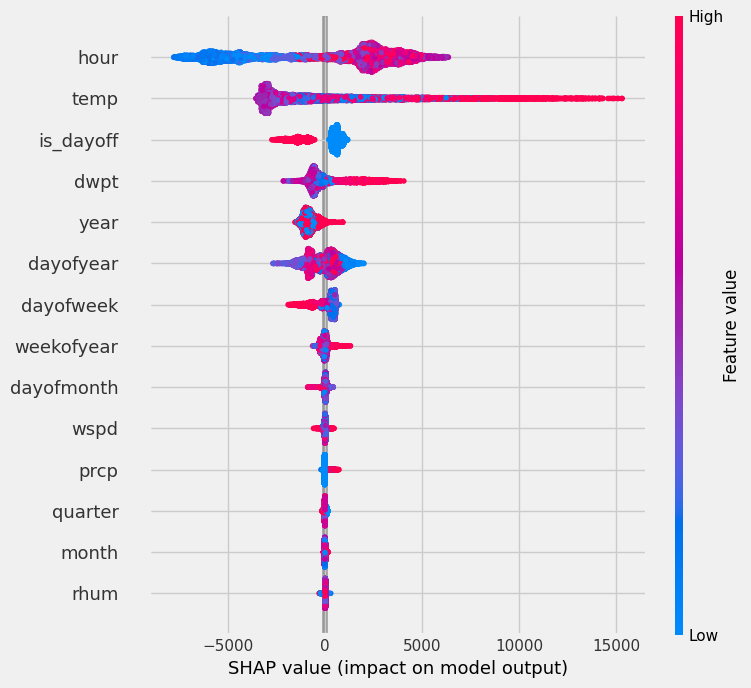

Generating SHAP summary plot (bar)...


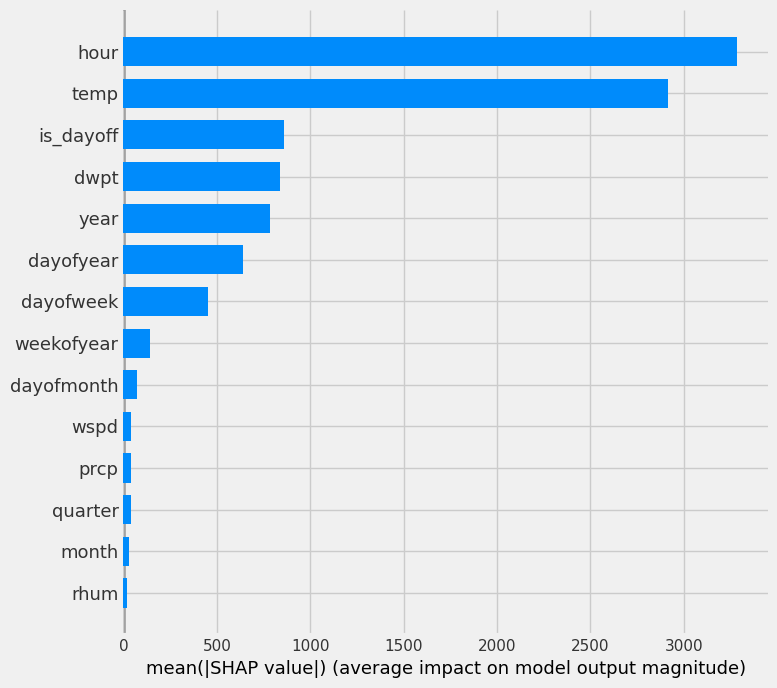

In [314]:
# Explain model predictions using SHAP
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(reg)
# Use the validation set for SHAP values
shap_values = explainer.shap_values(X_val)
print("SHAP values calculated.")

# Plot SHAP summary plot (beeswarm)
print("Generating SHAP summary plot (beeswarm)...")
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)
plt.show() # Ensure plot is displayed

# Plot SHAP summary plot (bar)
print("Generating SHAP summary plot (bar)...")
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, plot_type="bar")
plt.show() # Ensure plot is displayed

# Forecast on Test Set and Evaluate

Use the trained model to make predictions on the unseen test set. Visualize the predictions against the actual values.

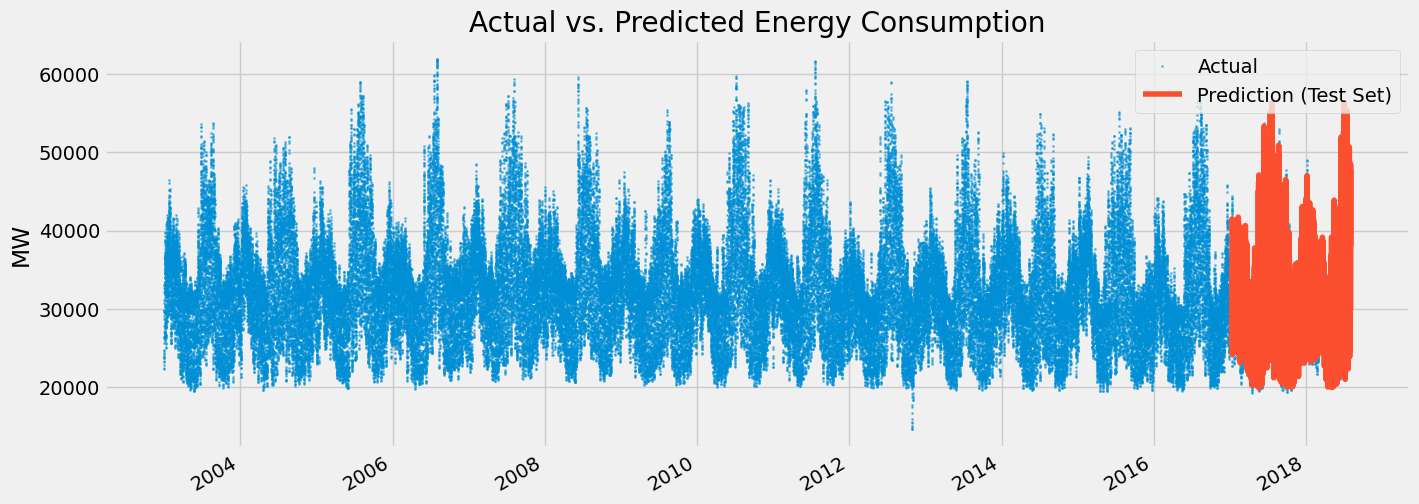

In [315]:
# Make predictions on the test set
test_df['MW_Prediction'] = reg.predict(X_test)

# Combine train/val/test for plotting full series (add target back to train/val)
train_df_plot = train_df.copy()
train_df_plot[TARGET] = y_train
val_df_plot = val_df.copy()
val_df_plot[TARGET] = y_val
all_df = pd.concat([train_df_plot, val_df_plot, test_df], sort=False)

# Plot actuals vs predictions for the entire dataset (test predictions highlighted)
fig, ax = plt.subplots(figsize=(15, 6))
all_df[TARGET].plot(ax=ax, label='Actual', style='.', alpha=0.5, ms=2)
test_df['MW_Prediction'].plot(ax=ax, label='Prediction (Test Set)', style='-')
ax.set_title('Actual vs. Predicted Energy Consumption')
ax.set_ylabel('MW')
ax.legend()
plt.show()

## Visualize Forecast for a Specific Period

Zoom in on a specific week in the test set to better visualize the model's performance day-to-day.

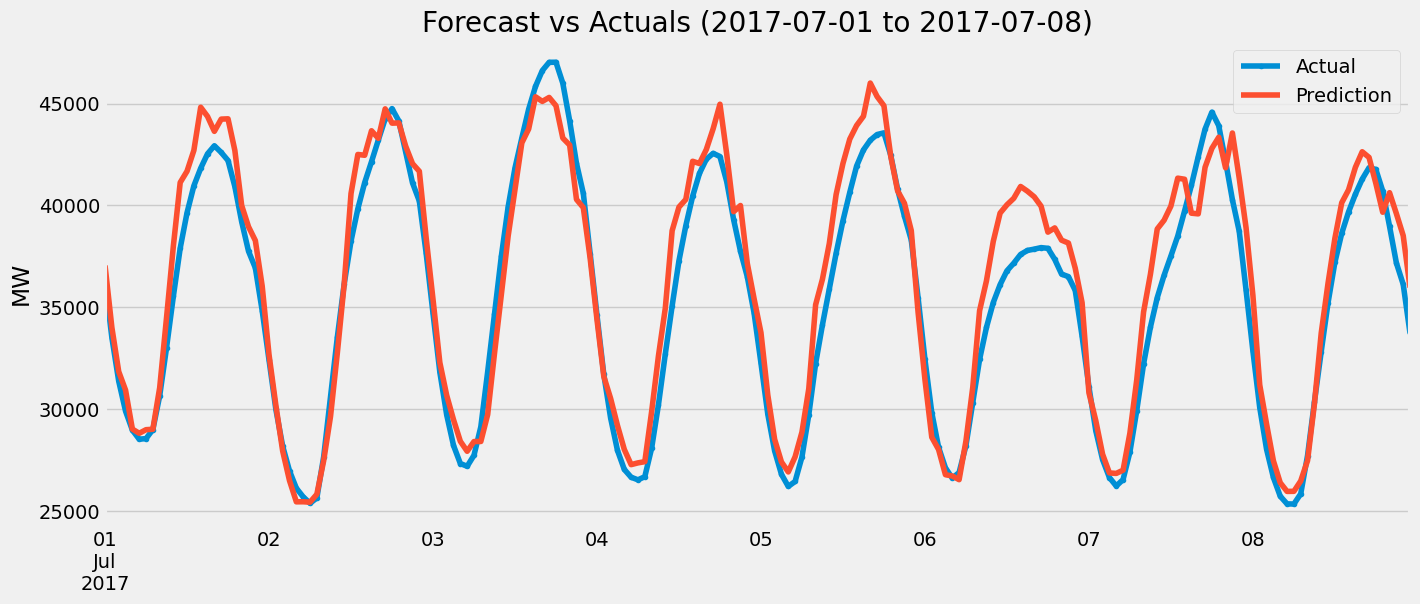

In [316]:
# Plot forecast vs actuals for a specific week in the test set
start_date = '2017-07-01'
end_date = '2017-07-08'

fig, ax = plt.subplots(figsize=(15, 6))
test_df.loc[start_date:end_date][TARGET].plot(ax=ax, label='Actual', style='.-')
test_df.loc[start_date:end_date]['MW_Prediction'].plot(ax=ax, label='Prediction', style='-')
ax.set_title(f'Forecast vs Actuals ({start_date} to {end_date})')
ax.set_ylabel('MW')
ax.legend()
plt.show()

## Test Set Error Metrics

Evaluate the model's performance on the held-out test set using standard regression metrics:

*   **Root Mean Squared Error (RMSE):** Square root of the average squared differences between prediction and actual observation. Sensitive to large errors.
*   **Mean Absolute Error (MAE):** Average of the absolute differences between prediction and actual observation. Interpretable in the same units as the target.
*   **Mean Absolute Percentage Error (MAPE):** Average of the absolute percentage errors. Useful for relative error assessment, but can be problematic if actual values are close to zero.

MAPE provides an intuitive percentage error but requires careful implementation to avoid division by zero.

In [317]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero or near-zero values
    mask = y_true != 0
    if not np.all(mask):
        print("Warning: Zero values found in y_true, MAPE calculation excludes these points.")
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

Calculate and display the error metrics on the test set.

In [318]:
y_true_test = test_df[TARGET]
y_pred_test = test_df['MW_Prediction']

rmse = np.sqrt(mean_squared_error(y_true=y_true_test, y_pred=y_pred_test))
mae = mean_absolute_error(y_true=y_true_test, y_pred=y_pred_test)
mape = mean_absolute_percentage_error(y_true=y_true_test, y_pred=y_pred_test)

print("--- Test Set Error Metrics ---")
print(f"RMSE: {rmse:,.2f} MW")
print(f"MAE:  {mae:,.2f} MW")
print(f"MAPE: {mape:.2f}%")

--- Test Set Error Metrics ---
RMSE: 1,539.62 MW
MAE:  1,191.56 MW
MAPE: 3.87%


## Error Analysis

Analyze the prediction errors further. Calculate the error and absolute error for each prediction. Aggregate these errors by day to identify days where the model performed particularly well or poorly on average.

In [322]:
# Calculate error and absolute error for each prediction
test_df['error'] = test_df[TARGET] - test_df['MW_Prediction']
test_df['abs_error'] = test_df['error'].abs()

# Group by date and calculate mean errors
error_by_day = test_df.groupby(test_df.index.date) \
    .agg(mean_PJME_MW=('PJME_MW', 'mean'),
         mean_MW_Prediction=('MW_Prediction', 'mean'),
         mean_error=('error', 'mean'),
         mean_abs_error=('abs_error', 'mean'))

# Add weekday name for context
error_by_day['weekday'] = pd.to_datetime(error_by_day.index).strftime('%A')

print("Top 10 Days with Worst Mean Absolute Error:")
error_by_day.sort_values('mean_abs_error', ascending=False).head(10)

Top 10 Days with Worst Mean Absolute Error:


,mean_PJME_MW,mean_MW_Prediction,mean_error,mean_abs_error,weekday
2017-02-25,24344.458333,28328.087891,-3983.630941,3983.630941,Saturday
2017-02-24,26445.083333,30201.458984,-3756.374919,3756.374919,Friday
2017-12-31,39016.000000,35304.312500,3711.686686,3711.686686,Sunday
2018-02-21,27572.500000,30924.638672,-3352.138590,3352.138590,Wednesday
2018-07-05,42402.375000,39281.335938,3121.039225,3132.492839,Thursday
2017-03-02,28309.083333,31360.818359,-3051.735352,3051.735352,Thursday
2017-02-23,27663.416667,30664.994141,-3001.578939,3001.578939,Thursday
2017-02-20,27070.583333,30068.468750,-2997.885661,2997.885661,Monday
2017-02-19,24555.500000,27548.033203,-2992.533285,2992.533285,Sunday
2017-03-01,27574.125000,30474.583984,-2900.457357,2900.457357,Wednesday


In [323]:
print("\nTop 10 Days with Best Mean Absolute Error:")
error_by_day.sort_values('mean_abs_error', ascending=True).head(10)


Top 10 Days with Best Mean Absolute Error:


,mean_PJME_MW,mean_MW_Prediction,mean_error,mean_abs_error,weekday
2017-12-23,28380.250000,28262.142578,118.107829,212.315999,Saturday
2018-05-06,23796.083333,23875.375000,-79.291504,303.982585,Sunday
2017-11-01,28511.458333,28425.820312,85.638102,308.338298,Wednesday
2018-05-19,24720.291667,24991.320312,-271.028402,329.193766,Saturday
2017-05-13,24752.333333,24957.884766,-205.550781,339.241374,Saturday
2017-06-25,31818.375000,32040.470703,-222.096110,369.091227,Sunday
2017-04-25,27245.666667,27563.189453,-317.524333,381.552327,Tuesday
2018-04-15,25127.000000,24984.447266,142.551839,390.314372,Sunday
2017-10-29,24605.666667,24996.212891,-390.546875,394.052409,Sunday
2017-03-31,30181.041667,30569.076172,-388.033285,409.843180,Friday


## Plotting Example of a High-Error Day

Visualize the predictions versus actuals for one of the days identified as having a high average absolute error. This helps understand the model's behavior during challenging periods.

Plotting worst predicted day: 2017-02-25


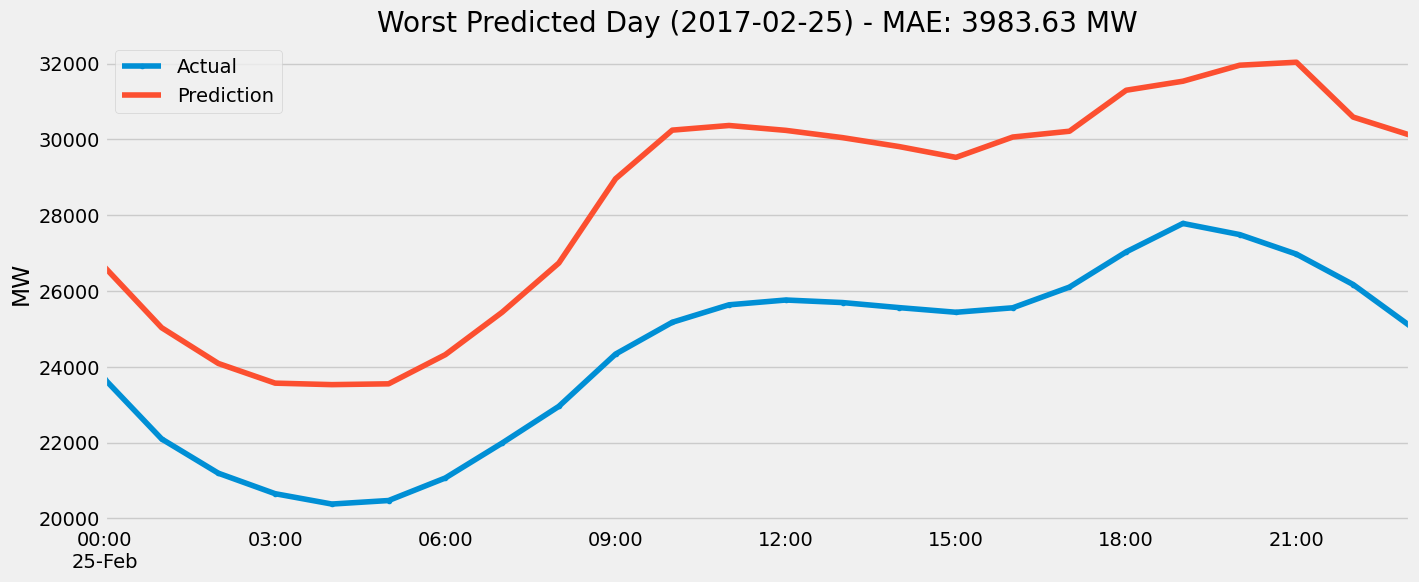

In [ ]:
# Find the date with the highest mean absolute error
worst_day = error_by_day['mean_abs_error'].idxmax()
worst_day_str = worst_day.strftime('%Y-%m-%d')

print(f"Plotting worst predicted day: {worst_day_str}")

fig, ax = plt.subplots(figsize=(15, 6))
test_df.loc[worst_day_str][TARGET].plot(ax=ax, label='Actual', style='.-')
test_df.loc[worst_day_str]['MW_Prediction'].plot(ax=ax, label='Prediction', style='-')
ax.set_title(f'Worst Predicted Day ({worst_day_str}) - MAE: {error_by_day.loc[worst_day, "mean_abs_error"]:.2f} MW')
ax.set_ylabel('MW')
ax.legend()
plt.show()

Plotting worst predicted day: 2017-12-23


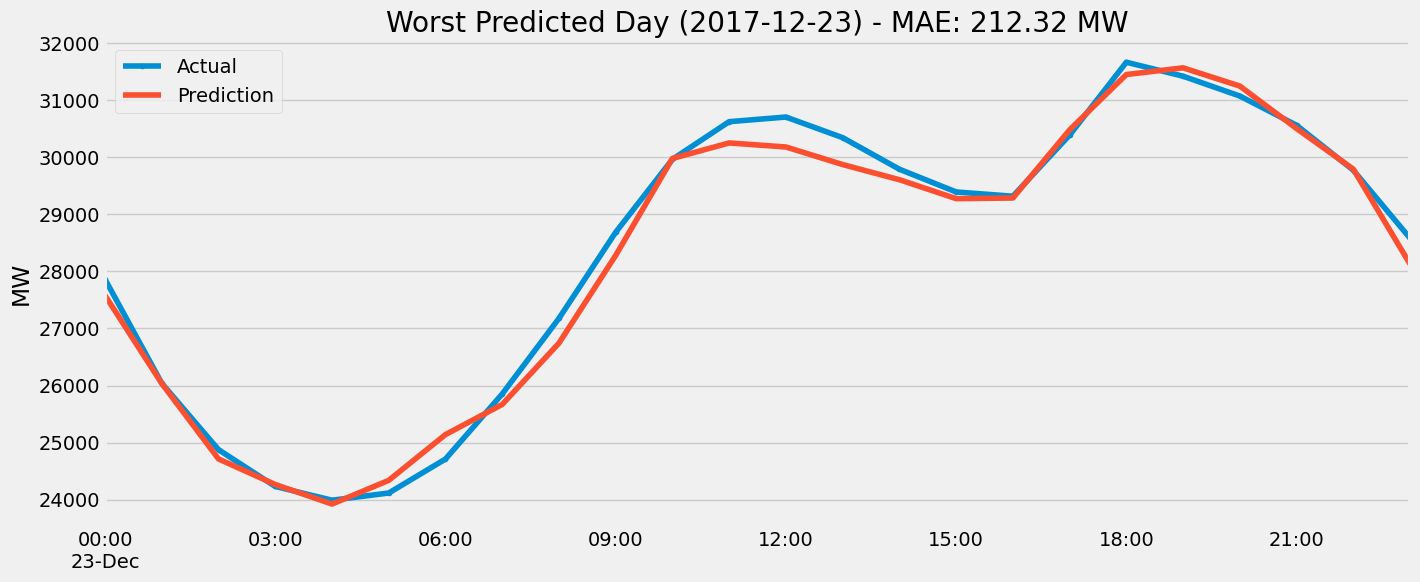

In [ ]:
# Find the date with the lowest mean absolute error
worst_day = error_by_day['mean_abs_error'].idxmin()
worst_day_str = worst_day.strftime('%Y-%m-%d')

print(f"Plotting worst predicted day: {worst_day_str}")

fig, ax = plt.subplots(figsize=(15, 6))
test_df.loc[worst_day_str][TARGET].plot(ax=ax, label='Actual', style='.-')
test_df.loc[worst_day_str]['MW_Prediction'].plot(ax=ax, label='Prediction', style='-')
ax.set_title(f'Best Predicted Day ({worst_day_str}) - MAE: {error_by_day.loc[worst_day, "mean_abs_error"]:.2f} MW')
ax.set_ylabel('MW')
ax.legend()
plt.show()